# Calculate DJIA

Calculate the Dow Jones Industrial Average using historical closing prices of the 30 companies, taken from this [Kaggle dataset](https://www.kaggle.com/dantest232/dow-jones-1jan2000-to-6dec2017).

In [183]:
import matplotlib.pylab as plt
% matplotlib inline
from matplotlib.pylab import rcParams
import numpy as np
import pandas as pd

import os

from IPython.display import display

rcParams['figure.figsize'] = 15, 6

filedir = 'dow30_dfs/'
filenames = os.listdir(filedir)
filenames = list(map(lambda x: filedir + x, filenames))

sample = pd.read_csv(filenames[0], parse_dates=['Date'], index_col='Date')
# only grab the last 2448 rows since Visa is missing over 1000 rows for some reason
nrows = 2448

prices = np.zeros(nrows)

for filename in filenames:
    df = pd.read_csv(filename, na_values=['null'])
    close = df['Close'].interpolate().values
    close = close[len(close) - nrows:]
    prices += close

# Dow Divisor as of 09/01/2017
d = 0.14523396877348

djia = prices / d

df = pd.DataFrame()
df['date'] = sample.index[sample.shape[0] - nrows:]
df['close'] = djia
df.set_index('date', drop=True, inplace=True)

ts = df['close']

display(ts.head())

date
2008-03-19    10517.252230
2008-03-20    10803.280419
2008-03-24    10921.815236
2008-03-25    10918.574314
2008-03-26    10827.657973
Name: close, dtype: float64

# Time Series Visualization and Exploration

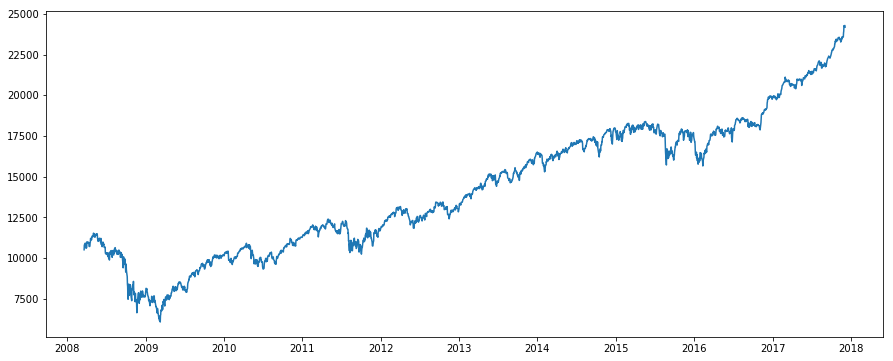

In [184]:
plt.plot(ts)

In [185]:
# Code from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=90)
    rolstd = pd.rolling_std(timeseries, window=90)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\Users\vgmd9_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
  import sys
C:\Users\vgmd9_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).std()
  


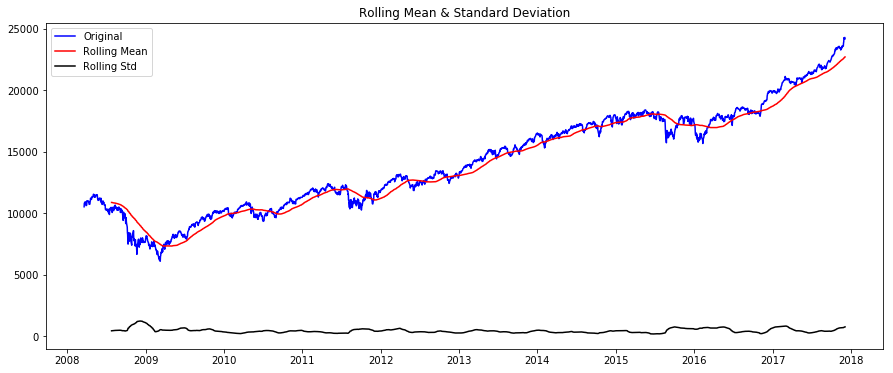

Results of Dickey-Fuller Test:
Test Statistic                    1.217224
p-value                           0.996103
#Lags Used                       18.000000
Number of Observations Used    2429.000000
Critical Value (1%)              -3.433045
Critical Value (5%)              -2.862731
Critical Value (10%)             -2.567404
dtype: float64


In [186]:
test_stationarity(ts)

In [187]:
# Start from mid-2009, after the market recession
ts = ts['2009-6-1':]

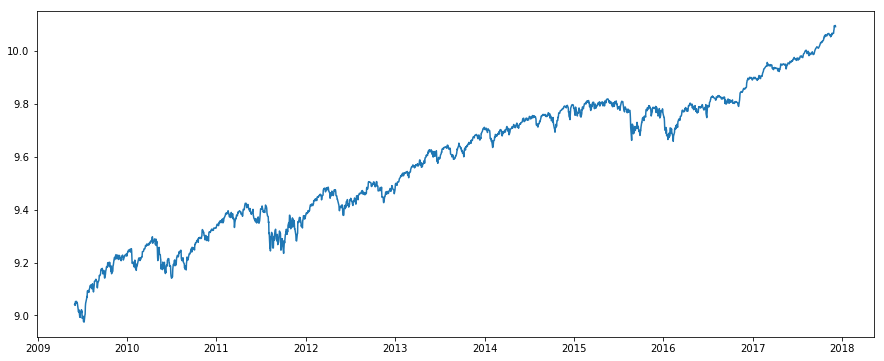

In [188]:
ts_log = np.log(ts)
plt.plot(ts_log)

# Exponentially Weighted Moving Average

C:\Users\vgmd9_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=90,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


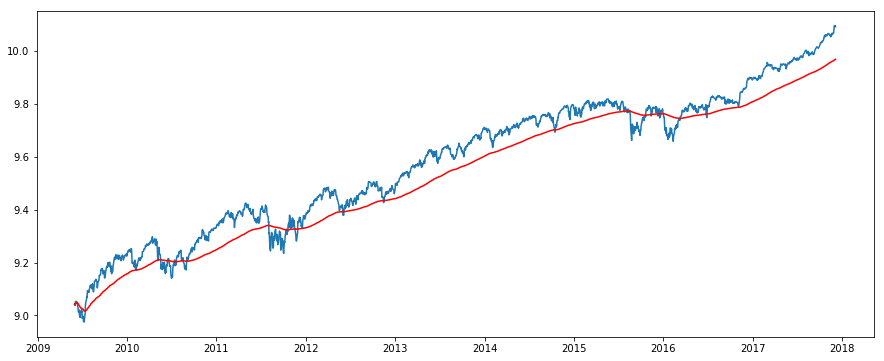

In [189]:
expwighted_avg = pd.ewma(ts_log, halflife=90)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

C:\Users\vgmd9_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
  import sys
C:\Users\vgmd9_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).std()
  


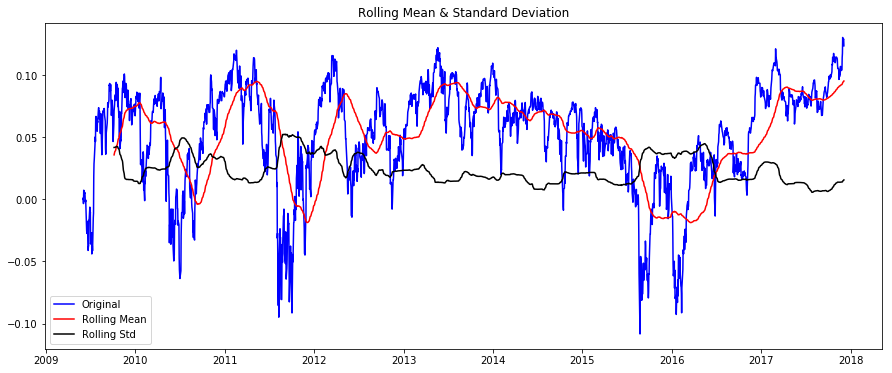

Results of Dickey-Fuller Test:
Test Statistic                   -4.139375
p-value                           0.000833
#Lags Used                       25.000000
Number of Observations Used    2120.000000
Critical Value (1%)              -3.433438
Critical Value (5%)              -2.862904
Critical Value (10%)             -2.567496
dtype: float64


In [190]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

# Differencing

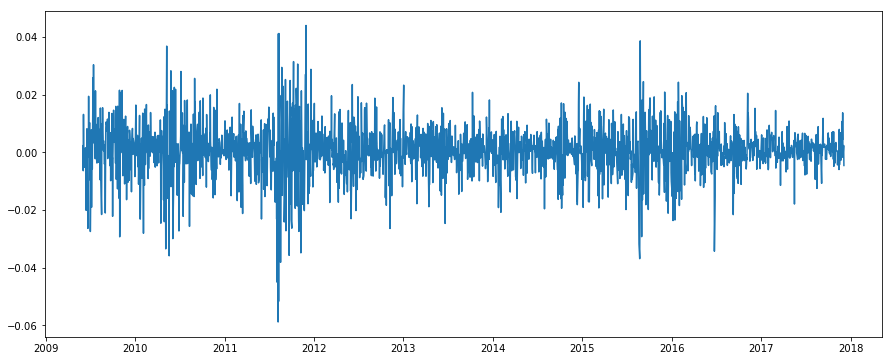

In [191]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

C:\Users\vgmd9_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
  import sys
C:\Users\vgmd9_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).std()
  


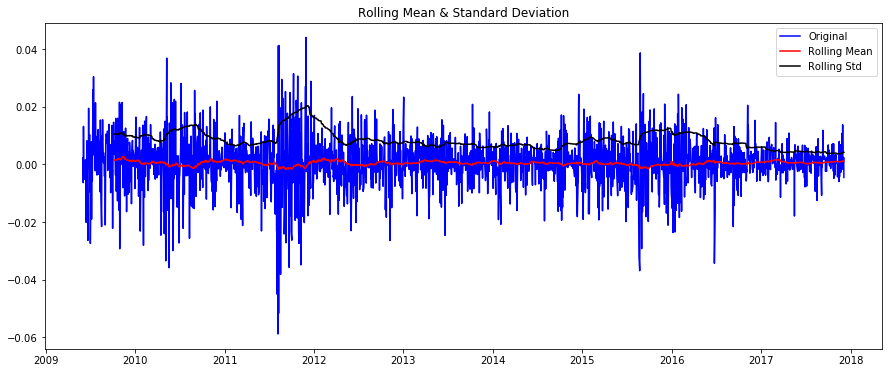

Results of Dickey-Fuller Test:
Test Statistic                -1.042980e+01
p-value                        1.621845e-18
#Lags Used                     2.400000e+01
Number of Observations Used    2.120000e+03
Critical Value (1%)           -3.433438e+00
Critical Value (5%)           -2.862904e+00
Critical Value (10%)          -2.567496e+00
dtype: float64


In [192]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# ARIMA

## ACF and PACF

Determine p and q values for ARIMA using ACF and PACF plots.

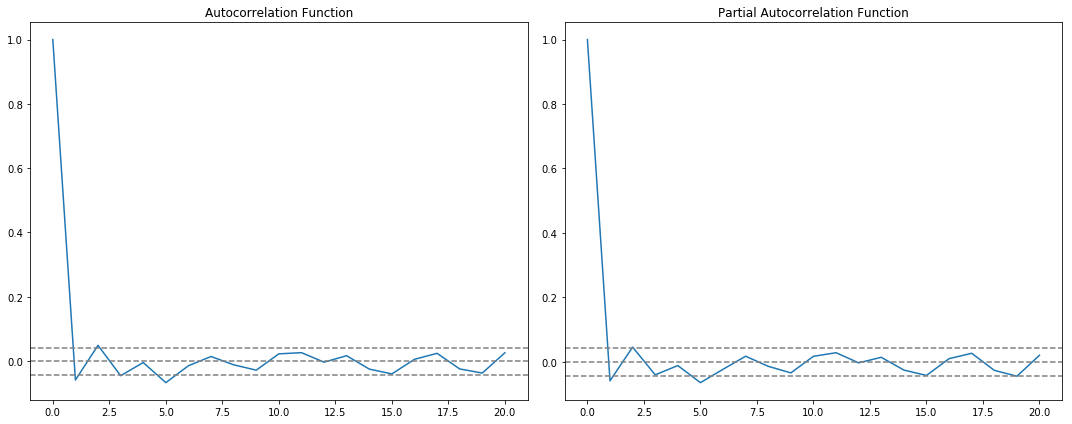

In [193]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## AR Model

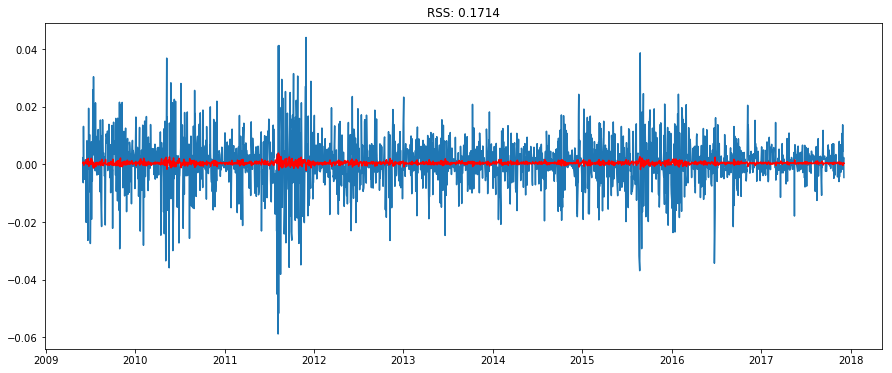

In [194]:
from statsmodels.tsa.arima_model import ARIMA

model_ar = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model_ar.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

## MA Model

C:\Users\vgmd9_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


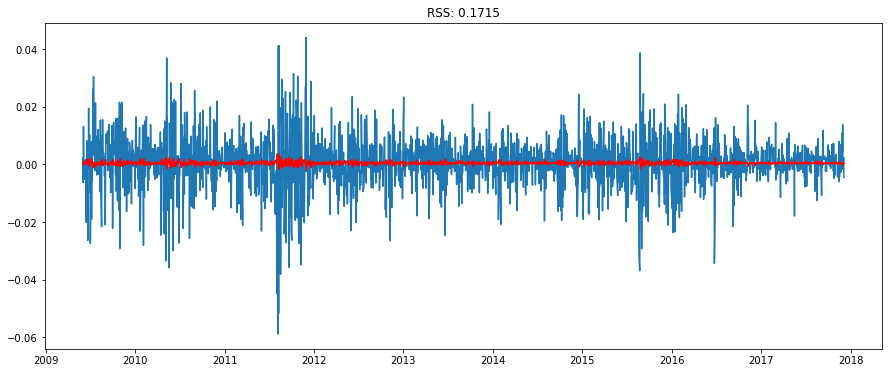

In [200]:
model_ma = ARIMA(ts_log, order=(0, 1, 1), freq='D')  
results_MA = model_ma.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

## Combined Model

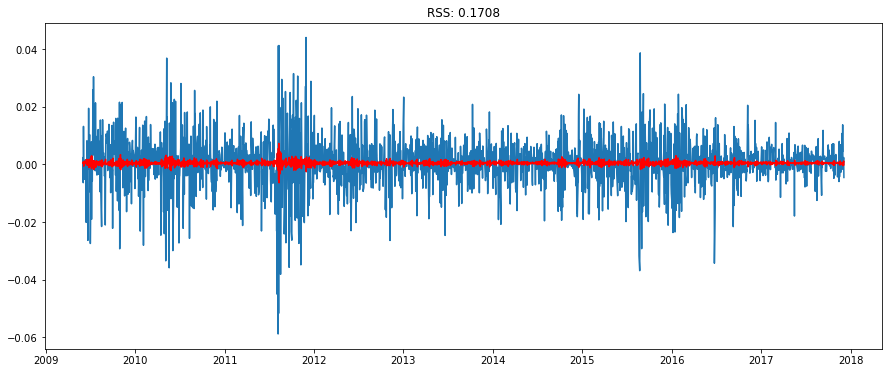

In [196]:
model_arima = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model_arima.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

## Original Scaling

In [214]:
# Get prediction for 12/31/2018
pred = results_MA.predict('2017-12-5', '2018-12-31')
pred = results_MA.fittedvalues.append(pred)

predictions_MA_diff = pd.Series(pred, copy=True)
print(predictions_MA_diff.head())

predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
print(predictions_MA_diff_cumsum.head())

2009-06-02    0.000490
2009-06-03    0.000390
2009-06-04    0.000852
2009-06-05   -0.000177
2009-06-08    0.000404
dtype: float64
2009-06-02    0.000490
2009-06-03    0.000880
2009-06-04    0.001732
2009-06-05    0.001556
2009-06-08    0.001960
dtype: float64
0.000490043467718


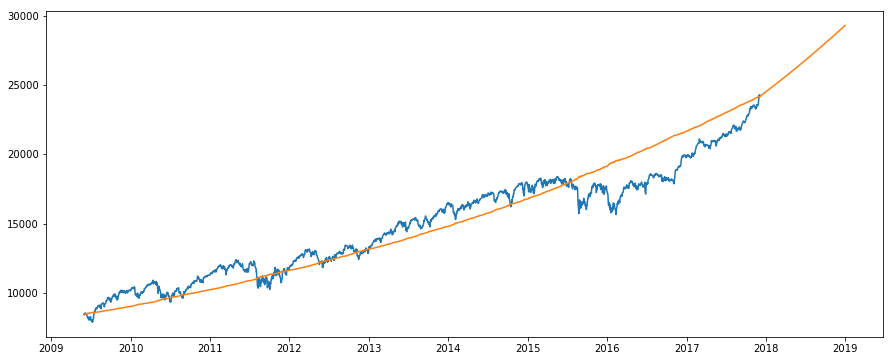

In [217]:
predictions_MA_log = pd.Series(ts_log.ix[0], index=pred.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA_log.head()

predictions_MA = np.exp(predictions_MA_log)
plt.plot(ts)
plt.plot(predictions_MA)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_MA-ts)**2)/len(ts)))

In [216]:
print("Predicted Price as of 12/31/2018: ", predictions_MA['2018-12-31'])

Predicted Price as of 12/31/2018:  29303.9038944
